<a href="https://colab.research.google.com/github/alemezrin/AproximacionNumericaDeCuencasDeAtraccionParaUnModeloDeWolbachiaConImperfecciones/blob/main/3_ModeloWolbachia4D_Imperfecto_(n%3D0_80%2Cv%3D1%2Cw%3D0).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importar bibliotecas necesarias

# Bibliotecas para gráficos interactivos y visualización
import altair as alt                       # Genera gráficos interactivos en 2D
import matplotlib.pyplot as plt            # Realiza gráficos 2D estáticos
import plotly.graph_objects as go          # Genera gráficos interactivos en 3D
from IPython.display import HTML           # Muestra contenido HTML en notebooks

# Bibliotecas para cálculos matemáticos y manipulación de datos
import numpy as np                         # Realiza operaciones matemáticas y manipulación de matrices
import math as ma                          # Proporciona funciones matemáticas
import pandas as pd                        # Manipula y analiza estructuras de datos

# Bibliotecas para resolver ecuaciones diferenciales y optimización
from scipy.integrate import odeint         # Resuelve sistemas de ecuaciones diferenciales
from scipy.optimize import root            # Encuentra raíces de funciones, usado para resolver puntos de equilibrio

# Estilo de gráficos 2D
plt.style.use("bmh")                       # Establece el estilo de los gráficos 2D

In [ ]:
# Parámetros del modelo
r_n = 0.5			              # Proporción primaria de sexos en mosquitos silvestres
r_w = 0.5                   # Proporción primaria de sexos en mosquitos portadores de Wolbachia
p_n = 4.55                  # Número de huevos producidos por una hembra silvestre en promedio por día
p_w = 4.55 * 0.9            # Número de huevos producidos por una hembra portadora en promedio por día
sigma = 3.57 / 10000        # Parámetro de competencia
gamma = 1                   # Competitividad de apareamiento entre M_n vs M_w
mu_n = 0.04                 # Tasa de mortalidad natural de machos silvestres
mu_w = 0.04 / 0.9           # Tasa de mortalidad natural de machos portadores de Wolbachia
delta_n = 0.03              # Tasa de mortalidad natural de hembras silvestres
delta_w = 0.03 / 0.9        # Tasa de mortalidad natural de hembras portadoras de Wolbachia
n = 0.8                       # Fuerza de Incompatibilidad Citoplasmática (IC)
v = 1                       # Probabilidad de transmisión materna imperfecta (TMI)
w = 0                       # Pérdida de la infección por Wolbachia debido al estrés térmico
dias = 365                  # Días totales para evaluar la liberación
malla = 0.01                # Espaciado de los puntos en la gráfica

# Población inicial silvestre
Mn_0 = 10000                # Población inicial de machos silvestres
Fn_0 = 10000                # Población inicial de hembras silvestres

In [ ]:
# Definición del sistema de ecuaciones diferenciales del modelo
def wolbachia(X, t=None):

    """
    Calcula las tasas de cambio para el sistema de ecuaciones diferenciales del modelo Wolbachia.

    Parámetros:
    X : list
        Lista de variables del sistema [Mn, Fn, Mw, Fw].
    t : float, opcional
        Tiempo (no usado en esta función, pero puede ser necesario para algunos solvers).

    Retorna:
    EDO : list
        Lista de tasas de cambio [dMndt, dFndt, dMwdt, dFwdt].
    """

    # Variables del sistema de ecuaciones
    Mn = X[0]  # Población de machos silvestres
    Fn = X[1]  # Población de hembras silvestres
    Mw = X[2]  # Población de machos portadores de Wolbachia
    Fw = X[3]  # Población de hembras portadoras de Wolbachia

    # Cálculo de las tasas de cambio en el tiempo (t>0)
    dMndt = ( (  r_n   * p_n * Fn * ((Mn + ((1-n) * gamma * Mw)) / (Mn + (gamma * Mw))) +   r_w   * p_w * (1-v) * Fw) ) * np.exp(-sigma * (Mn + Fn + Mw + Fw)) + (w * Mw) - (mu_n * Mn)
    dFndt = ( ((1-r_n) * p_n * Fn * ((Mn + ((1-n) * gamma * Mw)) / (Mn + (gamma * Mw))) + (1-r_w) * p_w * (1-v) * Fw) ) * np.exp(-sigma * (Mn + Fn + Mw + Fw)) + (w * Fw) - (delta_n * Fn)
    dMwdt =   r_w   * p_w * v * Fw * np.exp(-sigma * (Mn + Fn + Mw + Fw)) - (w * Mw) - (mu_w * Mw)
    dFwdt = (1-r_w) * p_w * v * Fw * np.exp(-sigma * (Mn + Fn + Mw + Fw)) - (w * Fw) - (delta_w * Fw)

    # Solución del modelo en un instante de tiempo (t>0)
    EDO = [dMndt, dFndt, dMwdt, dFwdt]

    return EDO

In [ ]:
# Creacion del vector de tiempo
def tiempo(dia_final, dia_inicial=0, dia_cantidad=None):
    """
    Crea un vector de tiempo utilizando la función np.linspace.

    Parámetros:
    dia_final : int
        El último día del intervalo.
    dia_inicial : int, opcional, por defecto es 0
        El primer día del intervalo.
    dia_cantidad : int, opcional
        El número de puntos a generar en el vector. Si no se especifica, se generarán puntos entre dia_inicial y dia_final.

    Retorna:
    t : numpy.ndarray
        Vector de tiempo.
    """

    # Definir el número de puntos en el vector
    if dia_cantidad is None:
        dia_cantidad = dia_final - dia_inicial

    # Crear el vector de tiempo
    t = np.linspace(dia_inicial, dia_final, dia_cantidad + 1)

    return t

# Ejemplo
print(tiempo(365,1,3)) # Ejemplo 1
print(tiempo(8))       # Ejemplo 2

[  1.         122.33333333 243.66666667 365.        ]
[0. 1. 2. 3. 4. 5. 6. 7. 8.]


In [ ]:
# Poblacion total cuando el sistema esta igualado a 0 (Coexistencia)
Poblacion_c = (1/sigma) * np.log(((1-r_w) * (p_w * v)) / (w + delta_w))

print(Poblacion_c)

11534.501172009084


In [ ]:
# Función para verificar si hemos alcanzado la coexistencia con una tolerancia dada
def cerca_de_coexistencia(Poblacion_0, Poblacion_c, tolerancia=1e-5):
    return np.abs(Poblacion_0 - Poblacion_c) < tolerancia

# Función para encontrar el punto de equilibrio del sistema
def encontrar_punto_equilibrio(Mn_0, Fn_0, Poblacion_c, tolerancia=1e-5):
    # Búsqueda del punto de equilibrio en un rango de valores iniciales
    for i in range(int(Mn_0 * 0.25), Mn_0):
        for j in range(int(Fn_0 * 0.33), Fn_0):
            solucion = root(wolbachia, [i, j, i, j])
            if solucion.success:  # Verificar que root haya convergido
                Poblacion_0 = np.sum(solucion.x)
                if cerca_de_coexistencia(Poblacion_0, Poblacion_c, tolerancia):
                    return solucion.x, i, j  # Retorna la solución y las condiciones iniciales
    return None, None, None  # Si no se encuentra una solución válida

# Ejecución de la búsqueda del punto de equilibrio
solucion_c, Mn_0_eq, Fn_0_eq = encontrar_punto_equilibrio(Mn_0, Fn_0, Poblacion_c)

# Presentación de resultados
if solucion_c is not None:
    Mn_c, Fn_c, Mw_c, Fw_c = solucion_c
    print(f"Población total cuando el sistema está igualado a 0 (Coexistencia):\nP = Mn + Fn + Mw + Fw = {Poblacion_c}\n")
    print(f"Condición inicial para hallar la raíz cuando el sistema está igualado a 0 (Coexistencia):\nX0 = [Mn0, Fn0, Mw0, Fw0] = [{Mn_0_eq}, {Fn_0_eq}, {Mn_0_eq}, {Fn_0_eq}]\n")
    print(f"Raíz encontrada cuando el sistema está igualado a 0:\nEc = [Mn_c, Fn_c, Mw_c, Fw_c] = [{Mn_c}, {Fn_c}, {Mw_c}, {Fw_c}]")
else:
    print("No se encontró un punto de equilibrio que coincida con la población de coexistencia dentro de la tolerancia.")

Población total cuando el sistema está igualado a 0 (Coexistencia):
P = Mn + Fn + Mw + Fw = 11534.501172009084

Condición inicial para hallar la raíz cuando el sistema está igualado a 0 (Coexistencia):
X0 = [Mn0, Fn0, Mw0, Fw0] = [2500, 3300, 2500, 3300]

Raíz encontrada cuando el sistema está igualado a 0:
Ec = [Mn_c, Fn_c, Mw_c, Fw_c] = [3769.3102044257394, 5025.74693923432, 1174.0474407212062, 1565.3965876282748]


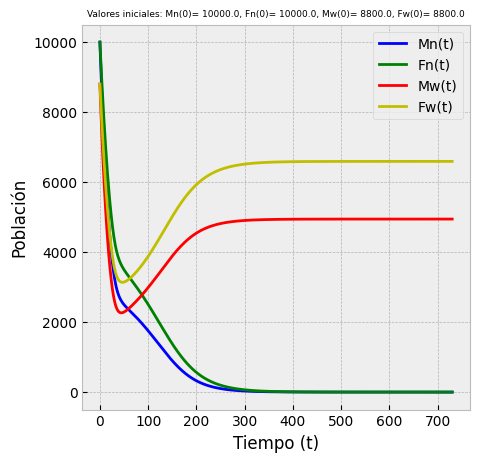

In [ ]:
# Creacion de graficas 2D
def graficas(numero_dias, numero_graficas, Mn_0, Fn_0, Mw_0=None, Fw_0=None):
    """
    Genera gráficas de la dinámica de poblaciones de mosquitos con y sin Wolbachia.

    Args:
      numero_dias: int, El número total de días para la simulación.
      numero_graficas: int, El número de gráficos a generar (puede variar entre 1 y más).
      Mn_0: float, Población inicial de machos sin Wolbachia.
      Fn_0: float, Población inicial de hembras sin Wolbachia.
      Mw_0: float, opcional, Población inicial de machos con Wolbachia. Si no se proporciona, se asume un porcentaje de Mn_0.
      Fw_0: float, opcional, Población inicial de hembras con Wolbachia. Si no se proporciona, se asume un porcentaje de Fn_0.
    """
    t = tiempo(numero_dias)  # Crear una vez el vector de tiempo

    if numero_graficas == 1:
        X_0 = [Mn_0, Fn_0, 0.60 * Mn_0 if Mw_0 is None else Mw_0, 0.30 * Fn_0 if Fw_0 is None else Fw_0]
        solucion = odeint(wolbachia, X_0, t)
        plt.figure(figsize=(5, 5))

        Mn, Fn, Mw, Fw = solucion[:, 0], solucion[:, 1], solucion[:, 2], solucion[:, 3]

        plt.plot(t, Mn, color='b', label='Mn(t)')
        plt.plot(t, Fn, color='g', label='Fn(t)')
        plt.plot(t, Mw, color='r', label='Mw(t)')
        plt.plot(t, Fw, color='y', label='Fw(t)')
        plt.title("Valores iniciales: Mn(0)= {:.1f}, Fn(0)= {:.1f}, Mw(0)= {:.1f}, Fw(0)= {:.1f}"
                  .format(Mn_0, Fn_0, X_0[2], X_0[3]), fontsize=6.5)
        plt.legend(loc='best')
        plt.ylabel('Población')
        plt.xlabel('Tiempo (t)')
        plt.show()

    elif 2 <= numero_graficas <= 4:
        X = []

        Mn_porcentaje, Fn_porcentaje = 0, 0
        crecimiento = 1 / (numero_graficas + 1)

        for i in range(1, numero_graficas + 1):
            Mn_porcentaje += crecimiento
            Fn_porcentaje += crecimiento

            Xi = [Mn_0, Fn_0, Mn_porcentaje * Mn_0, Fn_porcentaje * Fn_0]
            X.append(Xi)

        fig, axs = plt.subplots(1, numero_graficas, figsize=(5 * numero_graficas, 4))

        for i, condiciones in enumerate(X, start=1):
            solucion = odeint(wolbachia, condiciones, t)
            Mn, Fn, Mw, Fw = solucion[:, 0], solucion[:, 1], solucion[:, 2], solucion[:, 3]

            axs[i - 1].plot(t, Mn, label='Mn(t)', color='b')
            axs[i - 1].plot(t, Fn, label='Fn(t)', color='g')
            axs[i - 1].plot(t, Mw, label='Mw(t)', color='r')
            axs[i - 1].plot(t, Fw, label='Fw(t)', color='y')

            axs[i - 1].set_title("Valores iniciales: Mn(0)= {:.1f}, Fn(0)= {:.1f}, Mw(0)= {:.1f}, Fw(0)= {:.1f}"
                                 .format(Mn_0, Fn_0, crecimiento * i * Mn_0, crecimiento * i * Fn_0), fontsize=6)
            axs[i - 1].set_xlabel('Tiempo (t)')
            axs[i - 1].set_ylabel('Población')
            axs[i - 1].legend()

    else:
        X = []
        Mn_porcentaje, Fn_porcentaje = 0, 0
        crecimiento = 1 / (numero_graficas + 1)

        for i in range(1, numero_graficas + 1):
            Mn_porcentaje += crecimiento
            Fn_porcentaje += crecimiento

            Xi = [Mn_0, Fn_0, Mn_porcentaje * Mn_0, Fn_porcentaje * Fn_0]
            X.append(Xi)

        numero_filas = ma.ceil(numero_graficas / 4)
        fig, axs = plt.subplots(numero_filas, 4, figsize=(20, 4 * numero_filas))

        for i, condiciones in enumerate(X, start=1):
            solucion = odeint(wolbachia, condiciones, t)
            Mn, Fn, Mw, Fw = solucion[:, 0], solucion[:, 1], solucion[:, 2], solucion[:, 3]

            fila, columna = (i - 1) // 4, (i - 1) % 4

            axs[fila, columna].plot(t, Mn, label='Mn(t)', color='b')
            axs[fila, columna].plot(t, Fn, label='Fn(t)', color='g')
            axs[fila, columna].plot(t, Mw, label='Mw(t)', color='r')
            axs[fila, columna].plot(t, Fw, label='Fw(t)', color='y')

            axs[fila, columna].set_title("Valores iniciales: Mn(0)= {:.1f}, Fn(0)= {:.1f}, Mw(0)= {:.1f}, Fw(0)= {:.1f}"
                                         .format(Mn_0, Fn_0, crecimiento * i * Mn_0, crecimiento * i * Fn_0), fontsize=7)
            axs[fila, columna].set_xlabel('Tiempo (t)')
            axs[fila, columna].set_ylabel('Población')
            axs[fila, columna].legend()

        plt.tight_layout()
        plt.show()


# Ejemplo de uso para gráficas
graficas(numero_dias=730, numero_graficas=1, Mn_0=10000, Fn_0=10000, Mw_0=8800, Fw_0=8800)   # Ejemplo 1

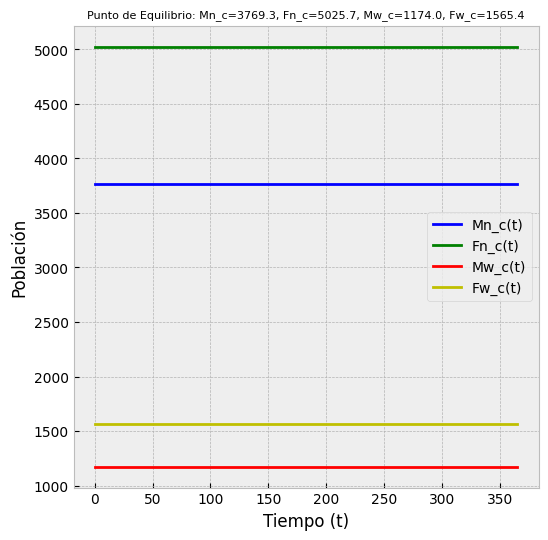

In [ ]:
# Creación de gráficas 2D para el Punto de Equilibrio
def graficaPE(numero_dias, Mn_c, Fn_c, Mw_c, Fw_c):
    """
    Grafica las poblaciones de mosquitos en función del tiempo para el punto de equilibrio.

    Args:
      numero_dias (int): Número total de días para la simulación.
      Mn_c (float): Población inicial de machos no infectados.
      Fn_c (float): Población inicial de hembras no infectadas.
      Mw_c (float): Población inicial de machos infectados.
      Fw_c (float): Población inicial de hembras infectadas.
    """
    t = tiempo(numero_dias)  # Crear una vez el vector de tiempo

    X_0 = [Mn_c, Fn_c, Mw_c, Fw_c]
    solucion = odeint(wolbachia, X_0, t)
    Mn, Fn, Mw, Fw = solucion[:, 0], solucion[:, 1], solucion[:, 2], solucion[:, 3]

    plt.figure(figsize=(6, 6))  # Ajuste de tamaño de figura

    plt.plot(t, Mn, color='b', label='Mn_c(t)')
    plt.plot(t, Fn, color='g', label='Fn_c(t)')
    plt.plot(t, Mw, color='r', label='Mw_c(t)')
    plt.plot(t, Fw, color='y', label='Fw_c(t)')

    plt.title("Punto de Equilibrio: Mn_c={:.1f}, Fn_c={:.1f}, Mw_c={:.1f}, Fw_c={:.1f}"
              .format(Mn_c, Fn_c, Mw_c, Fw_c), fontsize=8)  # Ajuste de tamaño de fuente
    plt.legend(loc='best')
    plt.ylabel('Población')
    plt.xlabel('Tiempo (t)')
    plt.grid(True)  # Añadir grid para mejor visualización
    plt.show()

# Ejemplo de uso de la función
graficaPE(numero_dias=365, Mn_c=Mn_c, Fn_c=Fn_c, Mw_c=Mw_c, Fw_c=Fw_c)

In [ ]:
# Listas para almacenar puntos de la cuenca de atracción
bala_si = []  # Puntos de la Cuenca de Atracción de Ew (bala roja)
bala_no = []  # Puntos de la Cuenca de Atracción de En (bala azul)

# Iterar sobre los valores posibles de Mw_0 y Fw_0
for Mw_0 in range(int(malla * Mn_0), Mn_0 + 1, int(malla * Mn_0)):
    for Fw_0 in range(int(malla * Fn_0), Fn_0 + 1, int(malla * Fn_0)):
        # condiciones iniciales
        X_0 = [Mn_0, Fn_0, Mw_0, Fw_0]

        # Resuelve el sistema de EDO
        solucion = odeint(wolbachia, X_0, tiempo(dias, 0, 1))

        # Extraer los valores en el tiempo final
        Mn = solucion[1][0]
        Fn = solucion[1][1]
        Mw = solucion[1][2]
        Fw = solucion[1][3]

        # Clasificación basada en las condiciones del equilibrio
        if Mn < Mn_c and Fn < Fn_c and Mw > Mw_c and Fw > Fw_c:
            bala_si.append([Fw_0 / Fn_0, Mw_0 / Mn_0])

        else:
            bala_no.append([Fw_0 / Fn_0, Mw_0 / Mn_0])

In [ ]:
# Crear un DataFrame con los datos
data_si = pd.DataFrame({
    'fraccion_Fsi': [bala[0] for bala in bala_si],
    'fraccion_Msi': [bala[1] for bala in bala_si]
})

data_no = pd.DataFrame({
    'fraccion_Fno': [bala[0] for bala in bala_no],
    'fraccion_Mno': [bala[1] for bala in bala_no]
})

# Definir el área de los puntos
area = 7

# Crear la gráfica con Altair para el caso con \textit{Wolbachia} (bala roja)
chart_si = alt.Chart(data_si).mark_circle(color='red').encode(
    x=alt.X('fraccion_Msi:Q', title='Mw(0)/Mn(0)'),
    y=alt.Y('fraccion_Fsi:Q', title='Fw(0)/Fn(0)'),
    size=alt.value(area),
    tooltip=['fraccion_Msi:Q', 'fraccion_Fsi:Q']
)

# Crear la gráfica con Altair para el caso sin \textit{Wolbachia} (bala azul)
chart_no = alt.Chart(data_no).mark_circle(color='blue').encode(
    x=alt.X('fraccion_Mno:Q', title='Mw(0)/Mn(0)'),
    y=alt.Y('fraccion_Fno:Q', title='Fw(0)/Fn(0)'),
    size=alt.value(area),
    tooltip=['fraccion_Mno:Q', 'fraccion_Fno:Q']
)

# Unir ambas gráficas
combined_chart = alt.layer(chart_si, chart_no).properties(
    width=550,
    height=400,
    title='Cuenca de Atracción de Ew (bala roja) y En (bala azul): Única Liberación'
).configure_axis(
    labelFontSize=12,
    titleFontSize=14
).configure_title(
    fontSize=16
).configure_legend(
    titleFontSize=14,
    labelFontSize=12
)

# Guardar la gráfica combinada como archivo HTML
combined_chart.save('scatter_plot_unido.html')

# Mostrar el archivo HTML en línea
HTML(filename='scatter_plot_unido.html')

In [ ]:
# Diccionario para rastrear el mínimo del primer elemento para cada segundo elemento
minimos_por_dia = {}

for pareja in bala_si:
    segundo_elemento = pareja[1]
    primer_elemento = pareja[0]

    # Si el segundo elemento no está en el diccionario o si el primer elemento es menor
    if segundo_elemento not in minimos_por_dia or primer_elemento < minimos_por_dia[segundo_elemento]:
        minimos_por_dia[segundo_elemento] = primer_elemento

# Convertir el diccionario en una lista de mínimos, multiplicando por 100
minimos = [[minimo*100, segundo_elemento*100] for segundo_elemento, minimo in minimos_por_dia.items()]

In [ ]:
# Crear un DataFrame con los datos
df = pd.DataFrame({'Mw(0)/Mn(0) (%):': [pareja[1] for pareja in minimos], 'Fw(0)/Fn(0) (%):': [pareja[0] for pareja in minimos]})

# Crear el gráfico en Altair
chart = alt.Chart(df).mark_line(point=True).encode(
    x=alt.X('Mw(0)/Mn(0) (%)::Q', title='Mw(0)/Mn(0) (%)'),
    y=alt.Y('Fw(0)/Fn(0) (%)::Q', title='Fw(0)/Fn(0) (%)'),
    color=alt.value('red'),  # Establece el color de la línea en rojo
    tooltip=['Mw(0)/Mn(0) (%):', 'Fw(0)/Fn(0) (%):']  # Muestra las coordenadas al pasar el cursor
).properties(
    width=400,
    height=300,
    title='Proporción mínima requerida para una única liberación'
).configure_axis(
    labelFontSize=12,
    titleFontSize=14
).configure_title(
    fontSize=14
).configure_legend(
    titleFontSize=14,
    labelFontSize=12
)

# Guardar la gráfica como un archivo HTML
chart.save('scatter_plot_convergencia.html')

# Mostrar el archivo HTML en línea
HTML(filename='scatter_plot_convergencia.html')

In [ ]:
# Inicialización de listas para los puntos de las cuencas de atracción
bala_si1 = []  # Puntos de las Cuenca de atracción de Ew (bala roja)
bala_no1 = []  # Puntos de las Cuenca de atracción de En (bala azul)

# Iterar sobre las posibles condiciones iniciales
for Mw11 in range(int(0.01 * Mn_0), Mn_0 + 1, int(0.01 * Mn_0)):
    for Fw11 in range(int(0.01 * Fn_0), Fn_0 + 1, int(0.01 * Fn_0)):
        # condiciones iniciales
        X_01 = [Mn_0, Fn_0, Mw11, Fw11]

        # Resolver el sistema de EDO hasta el tiempo máximo
        for t in range(1, dias + 1):
          solucion1 = odeint(wolbachia, X_01, tiempo(t, 0, 1))

          Mn1 = solucion1[1][0]
          Fn1 = solucion1[1][1]
          Mw1 = solucion1[1][2]
          Fw1 = solucion1[1][3]

          # Verificar si se establece Wolbachia
          if Mn1 < Mn_c and Fn1< Fn_c and Mw1 > Mw_c and Fw1 > Fw_c:
            bala_si1.append([Fw11 / Fn_0, Mw11 / Mn_0, t])
            break # Salir del bucle de tiempo

          else:
            # Si no se estableció Wolbachia en el rango de tiempo
            bala_no1.append([Fw11 / Fn_0, Mw11 / Mn_0])

In [ ]:
# Definimos los datos de prueba
ys1 = [x[0] for x in bala_si1]
xs1 = [y[1] for y in bala_si1]
zs1 = [z[2] for z in bala_si1]
area1 = 10  # 0 to 15 point radio

# Crear la figura
fig = go.Figure()

# Agregar los datos a la gráfica
fig.add_trace(go.Scatter3d(
    x=xs1,
    y=ys1,
    z=zs1,
    mode='markers',
    marker=dict(
        size=area1,
        color='red',                # color de los puntos
        opacity=0.8
    ),
    hovertemplate=
        'M<sub>w</sub>(0)/M<sub>n</sub>(0): %{x}<br>' +
        'F<sub>w</sub>(0)/F<sub>n</sub>(0): %{y}<br>' +
        't: %{z}<extra></extra>'
))

# Configurar los ejes
fig.update_layout(
    scene=dict(
        xaxis=dict(title='M<sub>w</sub>(0)/M<sub>n</sub>(0)', range=[0, 1]),
        yaxis=dict(title='F<sub>w</sub>(0)/F<sub>n</sub>(0)', range=[0, 1]),
        zaxis=dict(title='t', range=[0, 365])
    ),
    margin=dict(r=0, l=0, b=0, t=0)  # Márgenes alrededor de la gráfica
)

# Mostrar la gráfica
fig.show()